In [9]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

import matplotlib.pyplot as plt


src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

# Changing to the pinball loss function.

Going to switch to pinball loss instead of set_loss as this is the generic approach in the littreature.

## Getting the data

We will try on both stock data and on normal data.

In [10]:
def get_stock_data(start_index, end_index):
    # Open txt file containg ticker names
    with open(r'C:\Users\tobyw\Documents\ChrisPython\ConformalProject\scripts\snptickers.txt', 'r') as f:
        all_tickers = f.read().splitlines()
        all_tickers.sort()
    
    stock_tickers = all_tickers[start_index:end_index]

    tickers = yq.Ticker(stock_tickers)
    all_price_data = tickers.history(period='5y', interval='1d')
    price_df = all_price_data[['close']].copy()

    stock_data_tuples = []

    # Some tickers in the list are incorrect or not trading so need 

    for ticker_symbol in price_df.index.get_level_values(0).unique():
        # Getting the volatilty data for each ticker
        ticker_price_data = price_df.loc[ticker_symbol]
        ticker_close = ticker_price_data['close'].to_numpy()

        # As when creating the volaility there is an intial NaN value, I will remove this.
        ticker_close = ticker_close[1:]

        # Appending it to the stock_data_tuples list, the last volatilty is used as the prediciton for the next.
        stock_data_tuples.append((ticker_close[:-1], ticker_close[1:]))
    

    return stock_data_tuples



In [53]:
stock_data = get_stock_data(0, 250)

In [12]:
normal_data = ACP_data.random_multi_shift(250, (2000,2001))

## The new Set method.

We will define the class with the new set_loss_function.

In [23]:
class pinball_AdaptiveCP(AdaptiveCP):
    def ACI_head(self, timeseries_data: tuple, gamma: float, start_point: int, custom_interval = None):
            xpred, y = timeseries_data
            alpha_t_list = [self.coverage_target]

            All_scores = self.score_function(xpred, y)

            err_t_list = []
            conformal_sets_list = []

            pinball_loss = self.vectorize_l()
            
            for i in range(start_point, len(All_scores)):
                Coverage_t = self.C_t(alpha_t_list[-1], All_scores, xpred[i], i, custom_interval)
                conformal_sets_list.append(Coverage_t)

                # Finding B_t
                low, high = 0, 999 
                possibilities = np.linspace(0, 1, 1000) # as 1 - 

                B_t = 1
                while low <= high:
                    mid = (high + low) // 2
                    possi = possibilities[mid]
                    Cpossi = self.C_t(possi, All_scores, xpred[i], i, custom_interval)

                    if Cpossi[0] < y[i] < Cpossi[1]:
                        B_t = possi
                        low = mid + 1
                    else:
                        high = mid - 1

                yield Coverage_t, pinball_loss(B_t, alpha_t_list[-1])

                error_t = AdaptiveCP.err_t(y[i], Coverage_t)
                err_t_list.append(error_t)

                alpha_t = min(max(alpha_t_list[-1] + (gamma * (self.coverage_target - error_t)), 0), 1)
                alpha_t_list.append(alpha_t)

            return False
        
    def AwACI(self, timeseries_data: tuple, interval_candidates: np.array = None, nu_sigma: tuple = (10**-3, 0.05), gamma: float = 0.05, title: str = None):
            
            _, y = timeseries_data

            chosen_interval_index = []
            err_t_list = []
            conformal_sets_list = []
            optimal_radius_list = []
            chosen_radius_list = []

            # Scale parameters, havent looked into scaling them best.
            sigma = nu_sigma[1]
            nu = nu_sigma[0] 

            if interval_candidates is None:
                interval_candidates = np.array(range(50, 550, 100))

            # To sync all of the heads we need to start at the max of all the candidates.
            start_point = max(interval_candidates) + 1
            i_count = start_point

            # Create the head and intitialse the weights.
            ACI_heads = [self.ACI_head(timeseries_data, gamma, start_point, interval) for interval in interval_candidates]
            interval_weights = np.array([1 for _ in range(len(interval_candidates))])
            
            # Continues calculating intervals until one of the heads stops.
            none_terminated = True

            while none_terminated: 
                head_sets = [] # Will contain the result from each head.
                pinball_loss_list = [] # Will contain the B_t values for each head.
                
                # Create the mass distribution for each head
                Wt = interval_weights.sum()

                interval_probabilites = interval_weights/Wt
            
                try:
                    # Create a list of the coverages for the different heads.
                    for head in ACI_heads:
                            coverage, loss = next(head)
                            head_sets.append(coverage)
                            pinball_loss_list.append(loss)

                except StopIteration: # One head is terminated.
                    none_terminated = False
                    break # You could but the return statement here

                # Choosing which head to use.
                chosen_set = random.choices(head_sets, weights=interval_probabilites, k=1)[0] # Using random module as numpy can not deal with tuples.
                conformal_sets_list.append(chosen_set)
                chosen_interval_index.append(head_sets.index(chosen_set))

                # TIME FRONTIER -------------

                # Seeing whether result lies within the set.
                err_true = AdaptiveCP.err_t(y[i_count], chosen_set)
                err_t_list.append(err_true)

                new_weights = interval_weights * np.exp(-1 * nu * np.array(pinball_loss_list)) 
                sumW, lenW = sum(new_weights), len(new_weights)
                final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
                interval_weights = final_weights

                # Incrementing the i-count
                i_count+=1

            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(50).mean().mean() # 50 is arbitary and could be improved.
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])

            return {
                    'model': title if title is not None else 'pinball AwACI',
                    'coverage_target': self.coverage_target,
                    'interval_candidates': interval_candidates,
                    'realised_interval_coverage': realised_interval_coverage,
                    'average_prediction_interval': average_prediction_interval,
                    'optimal_set_radius': optimal_radius_list, 
                    'chosen_set_radius': chosen_radius_list,
                    'conformal_sets': conformal_sets_list,
                    'error_t_list': err_t_list,
                    'chosen_interval_index': chosen_interval_index,
                    'start_point': start_point,
                    'interval_size': 50
                }

## Comparing the two

In [25]:
# Initilising each model.
target = 0.1
ACP = AdaptiveCP(0.1)
pinball_ACP = pinball_AdaptiveCP(0.1)

We will start with a simple absolute comparison.

In [34]:
# For the random data
vanila_dict = {'coverge':[], 'width':[]}
inverse_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(normal_data):
    vanila = ACP.AwACI(data, nu_sigma=(10**-3, 0.05))
    adapted = pinball_ACP.AwACI(data, nu_sigma=(0.01, 0.05))

    vanila_dict['coverge'].append(vanila['realised_interval_coverage'])
    vanila_dict['width'].append(vanila['average_prediction_interval'])

    inverse_dict['coverge'].append(adapted['realised_interval_coverage'])
    inverse_dict['width'].append(adapted['average_prediction_interval'])

    if i % 10 == 0:
        print(i)

# Computing the averages and printing.
vanila_coverage = np.mean(vanila_dict['coverge'])
vanila_width = np.mean(vanila_dict['width'])

inverse_coverage = np.mean(inverse_dict['coverge'])
inverse_width = np.mean(inverse_dict['width'])

print('\n')
print('Vanila average:', vanila_coverage, vanila_width)
print('pinball average:', inverse_coverage, inverse_width)

0
10
20
30
40
50
60
70
80
90


Vanila average: 0.8975720888610762 171.18269509793944
pinball average: 0.8982845093867333 189.06436065540106


0
10
20
30
40
50
60
70
80
90


ACI average: 0.8985761972692071 186.82216709085185


In [45]:
# For the random data
aci_dict = {x: {'coverge':[], 'width':[]} for x in range(50, 550, 100)}

for interval in range(50, 550, 100):
    for i, data in enumerate(normal_data):
        aci = ACP.ACI(data, custom_interval=interval, startpoint=450)

        aci_dict[interval]['coverge'].append(aci['realised_interval_coverage'])
        aci_dict[interval]['width'].append(aci['average_prediction_interval'])
       
    print(interval)

50
150
250
350
450


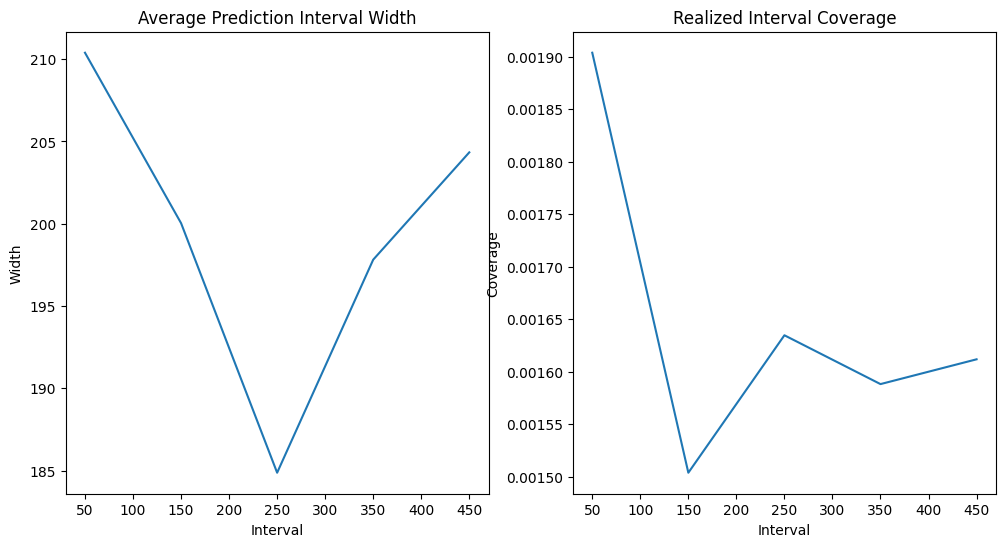

In [50]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot for width
plt.subplot(1, 2, 1)
plt.plot(list(aci_dict.keys()), [np.mean(aci_dict[x]['width']) for x in aci_dict.keys()])
plt.xlabel('Interval')
plt.ylabel('Width')
plt.title('Average Prediction Interval Width')

# Plot for coverage
plt.subplot(1, 2, 2)
plt.plot(list(aci_dict.keys()), [0.9 - np.mean(aci_dict[x]['coverge']) for x in aci_dict.keys()])
plt.xlabel('Interval')
plt.ylabel('Coverage')
plt.title('Realized Interval Coverage')

plt.show()

In [21]:
# Computing the averages and printing.
vanila_coverage = np.mean(vanila_dict['coverge'])
vanila_width = np.mean(vanila_dict['width'])

inverse_coverage = np.mean(inverse_dict['coverge'])
inverse_width = np.mean(inverse_dict['width'])

print('\n')
print('Vanila average:', vanila_coverage, vanila_width)
print('pinball average:', inverse_coverage, inverse_width)



Vanila average: 0.8973382483312474 308.5750585560234
pinball average: 0.8961897397788903 346.7692103090789


Comparing for the stock data.

In [35]:
# For the random data
vanila_dict = {'coverge':[], 'width':[]}
inverse_dict = {'coverge':[], 'width':[]}

for i, data in enumerate(stock_data):
    vanila = ACP.AwACI(data)
    adapted = pinball_ACP.AwACI(data)

    vanila_dict['coverge'].append(vanila['realised_interval_coverage'])
    vanila_dict['width'].append(vanila['average_prediction_interval'])

    inverse_dict['coverge'].append(adapted['realised_interval_coverage'])
    inverse_dict['width'].append(adapted['average_prediction_interval'])

    if i % 10 == 0:
        print(i)

# Computing the averages and printing.
vanila_coverage = np.mean(vanila_dict['coverge'])
vanila_width = np.mean(vanila_dict['width'])

inverse_coverage = np.mean(inverse_dict['coverge'])
inverse_width = np.mean(inverse_dict['width'])

print('\n')
print('Vanila average:', vanila_coverage, vanila_width)
print('Inverse average:', inverse_coverage, inverse_width)

0
10
20
30
40
50
60
70
80
90


Vanila average: 0.8971859892931524 11.28769718011449
Inverse average: 0.8974153380938091 11.27426863354629


In [51]:
# For the random data
aci_dict = {x: {'coverge':[], 'width':[]} for x in range(50, 550, 100)}

for interval in range(50, 550, 100):
    for i, data in enumerate(stock_data):
        aci = ACP.ACI(data, custom_interval=interval, startpoint=450)

        aci_dict[interval]['coverge'].append(aci['realised_interval_coverage'])
        aci_dict[interval]['width'].append(aci['average_prediction_interval'])
       
    print(interval)

50
150
250
350
450


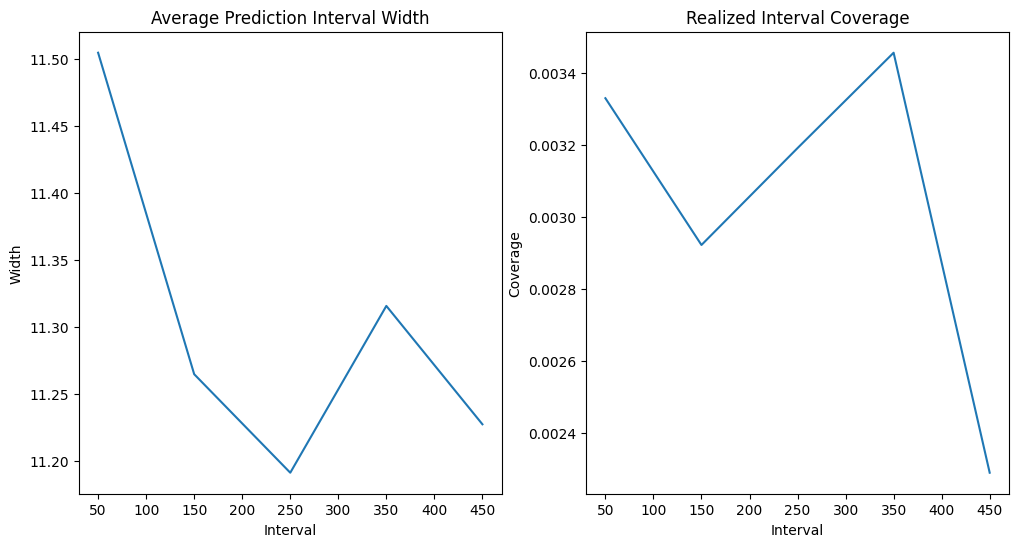

In [52]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot for width
plt.subplot(1, 2, 1)
plt.plot(list(aci_dict.keys()), [np.mean(aci_dict[x]['width']) for x in aci_dict.keys()])
plt.xlabel('Interval')
plt.ylabel('Width')
plt.title('Average Prediction Interval Width')

# Plot for coverage
plt.subplot(1, 2, 2)
plt.plot(list(aci_dict.keys()), [0.9 - np.mean(aci_dict[x]['coverge']) for x in aci_dict.keys()])
plt.xlabel('Interval')
plt.ylabel('Coverage')
plt.title('Realized Interval Coverage')

plt.show()

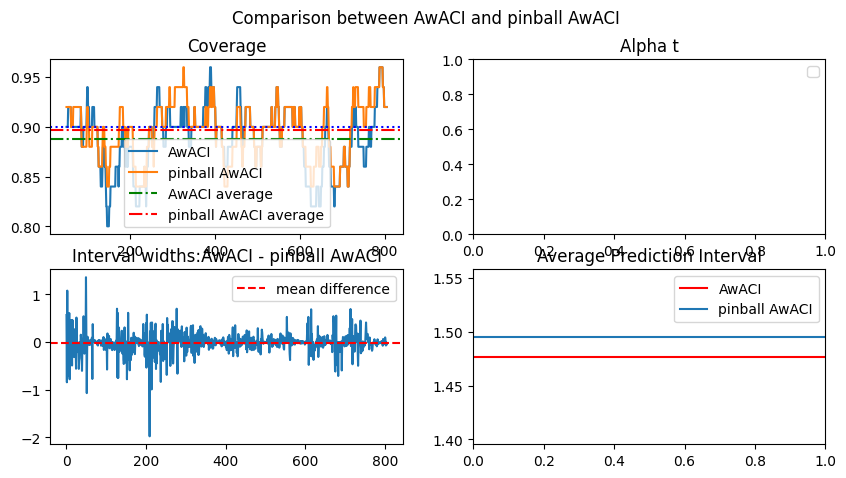

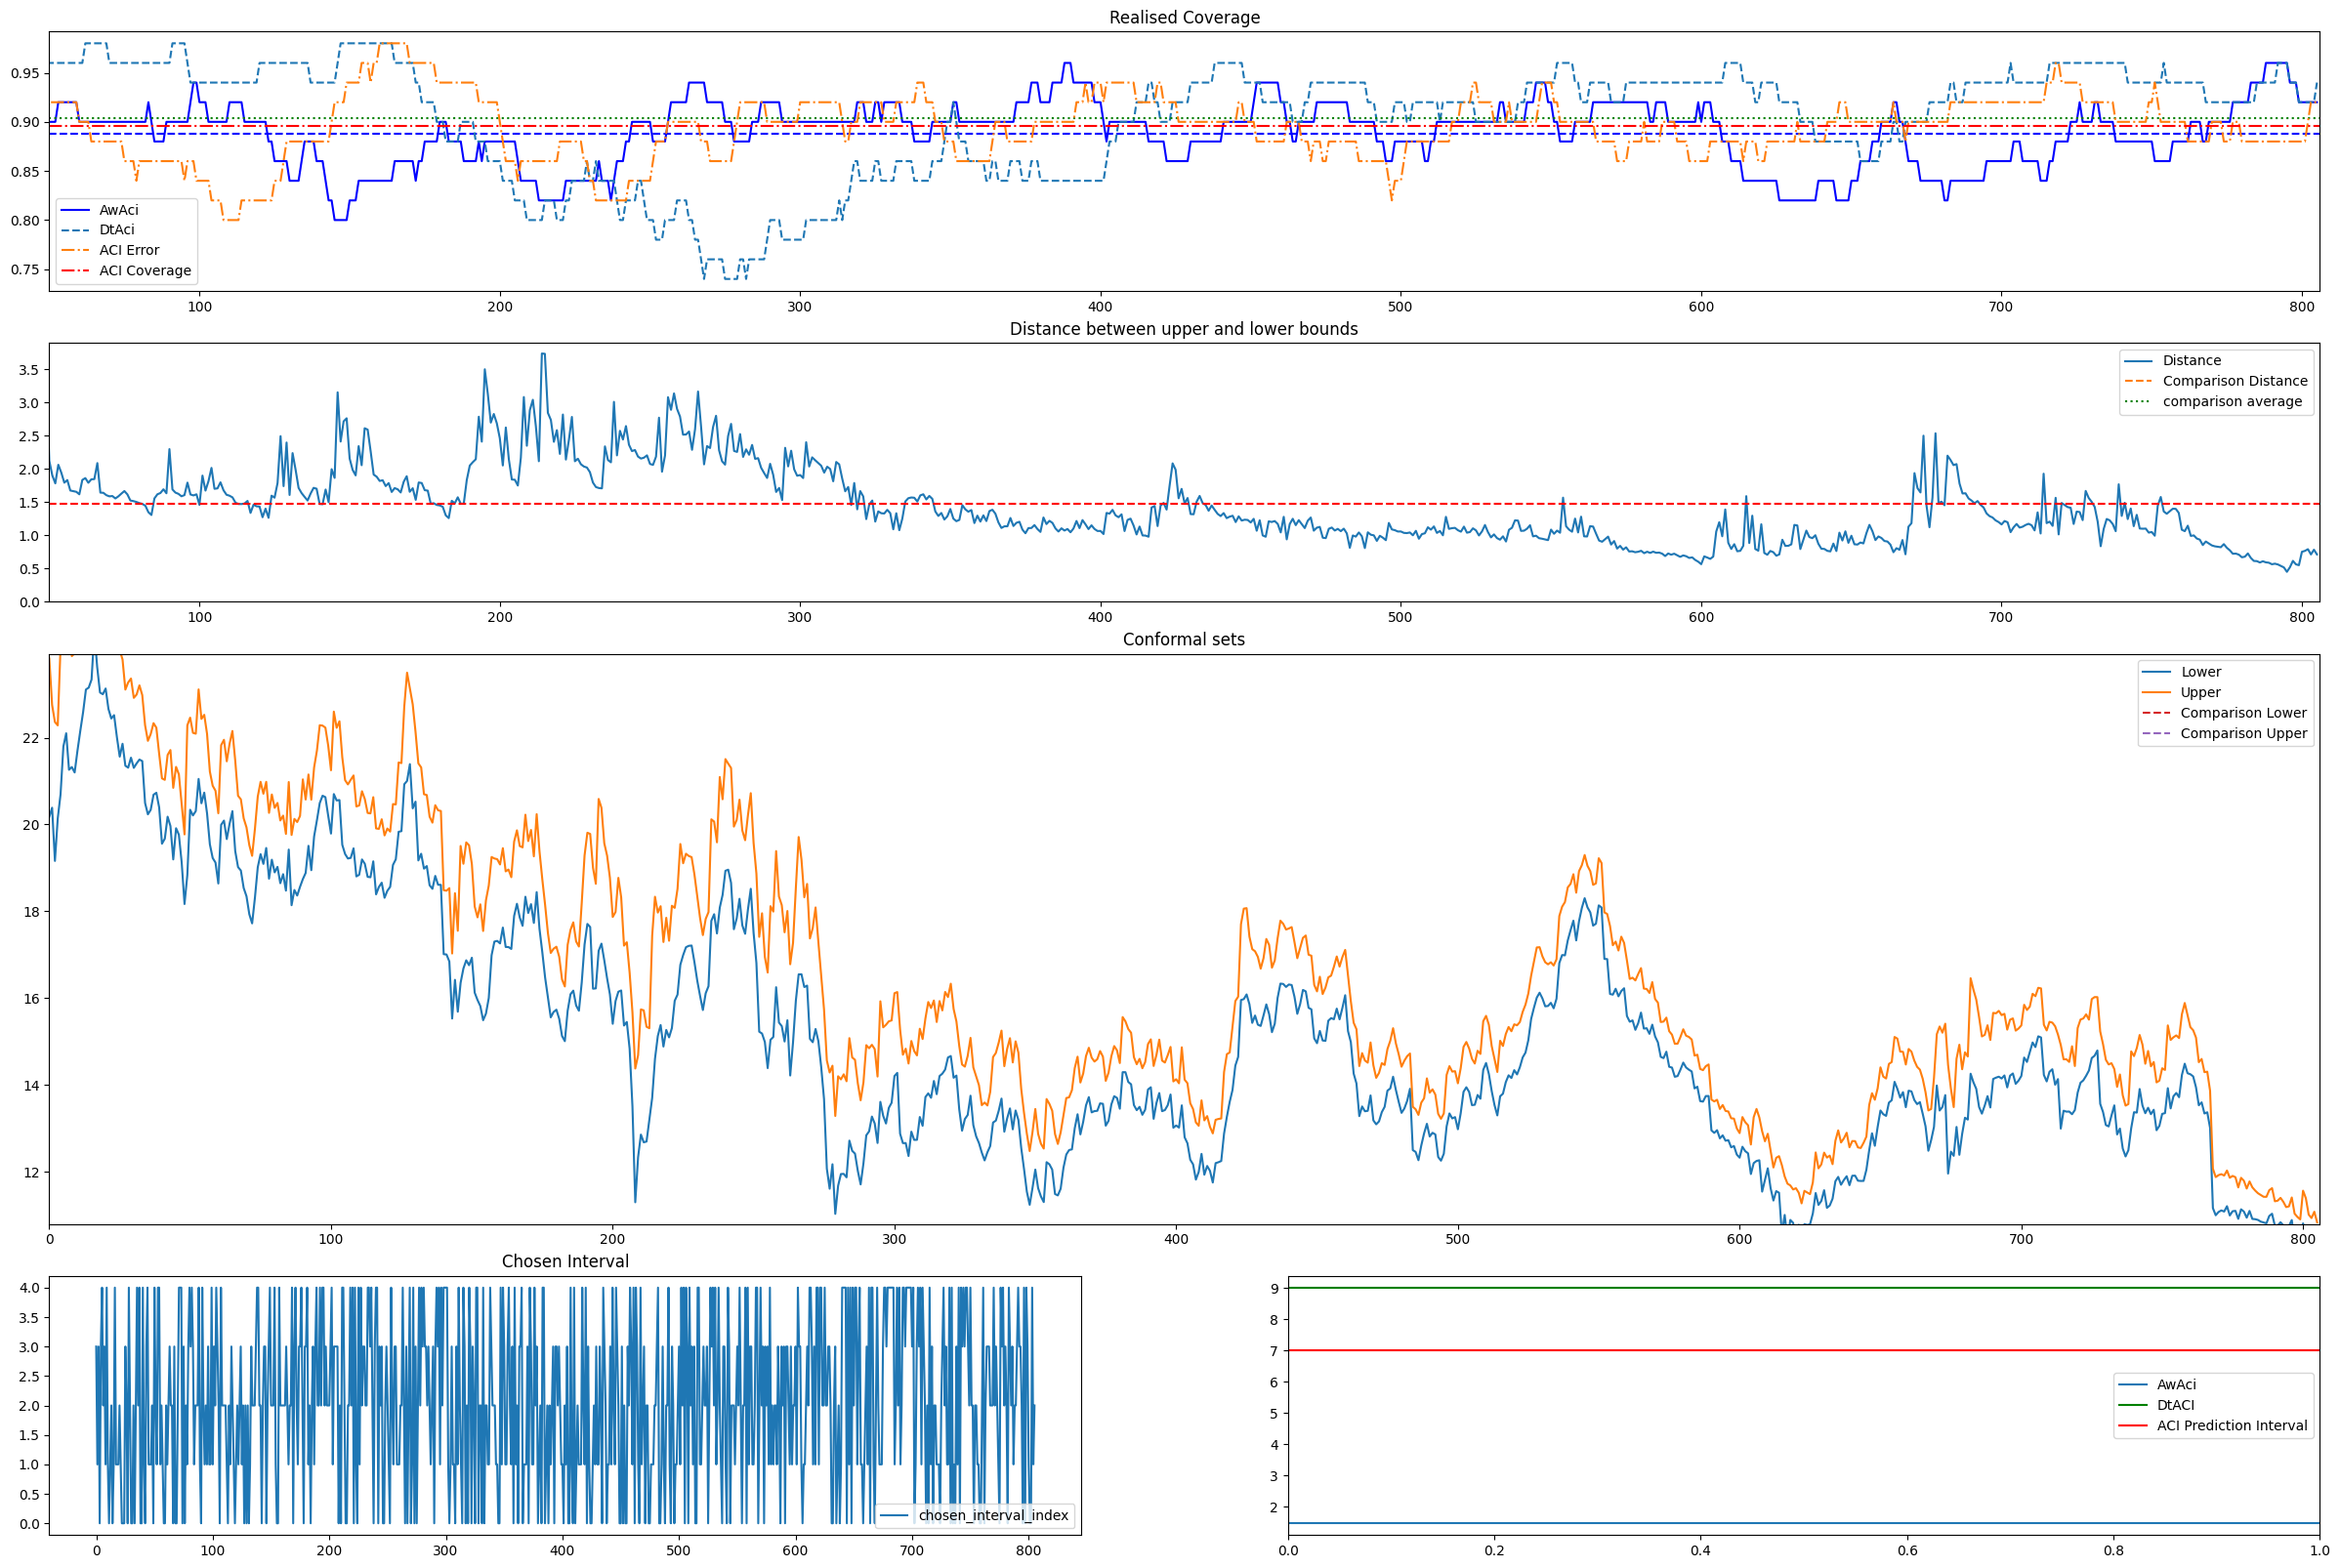

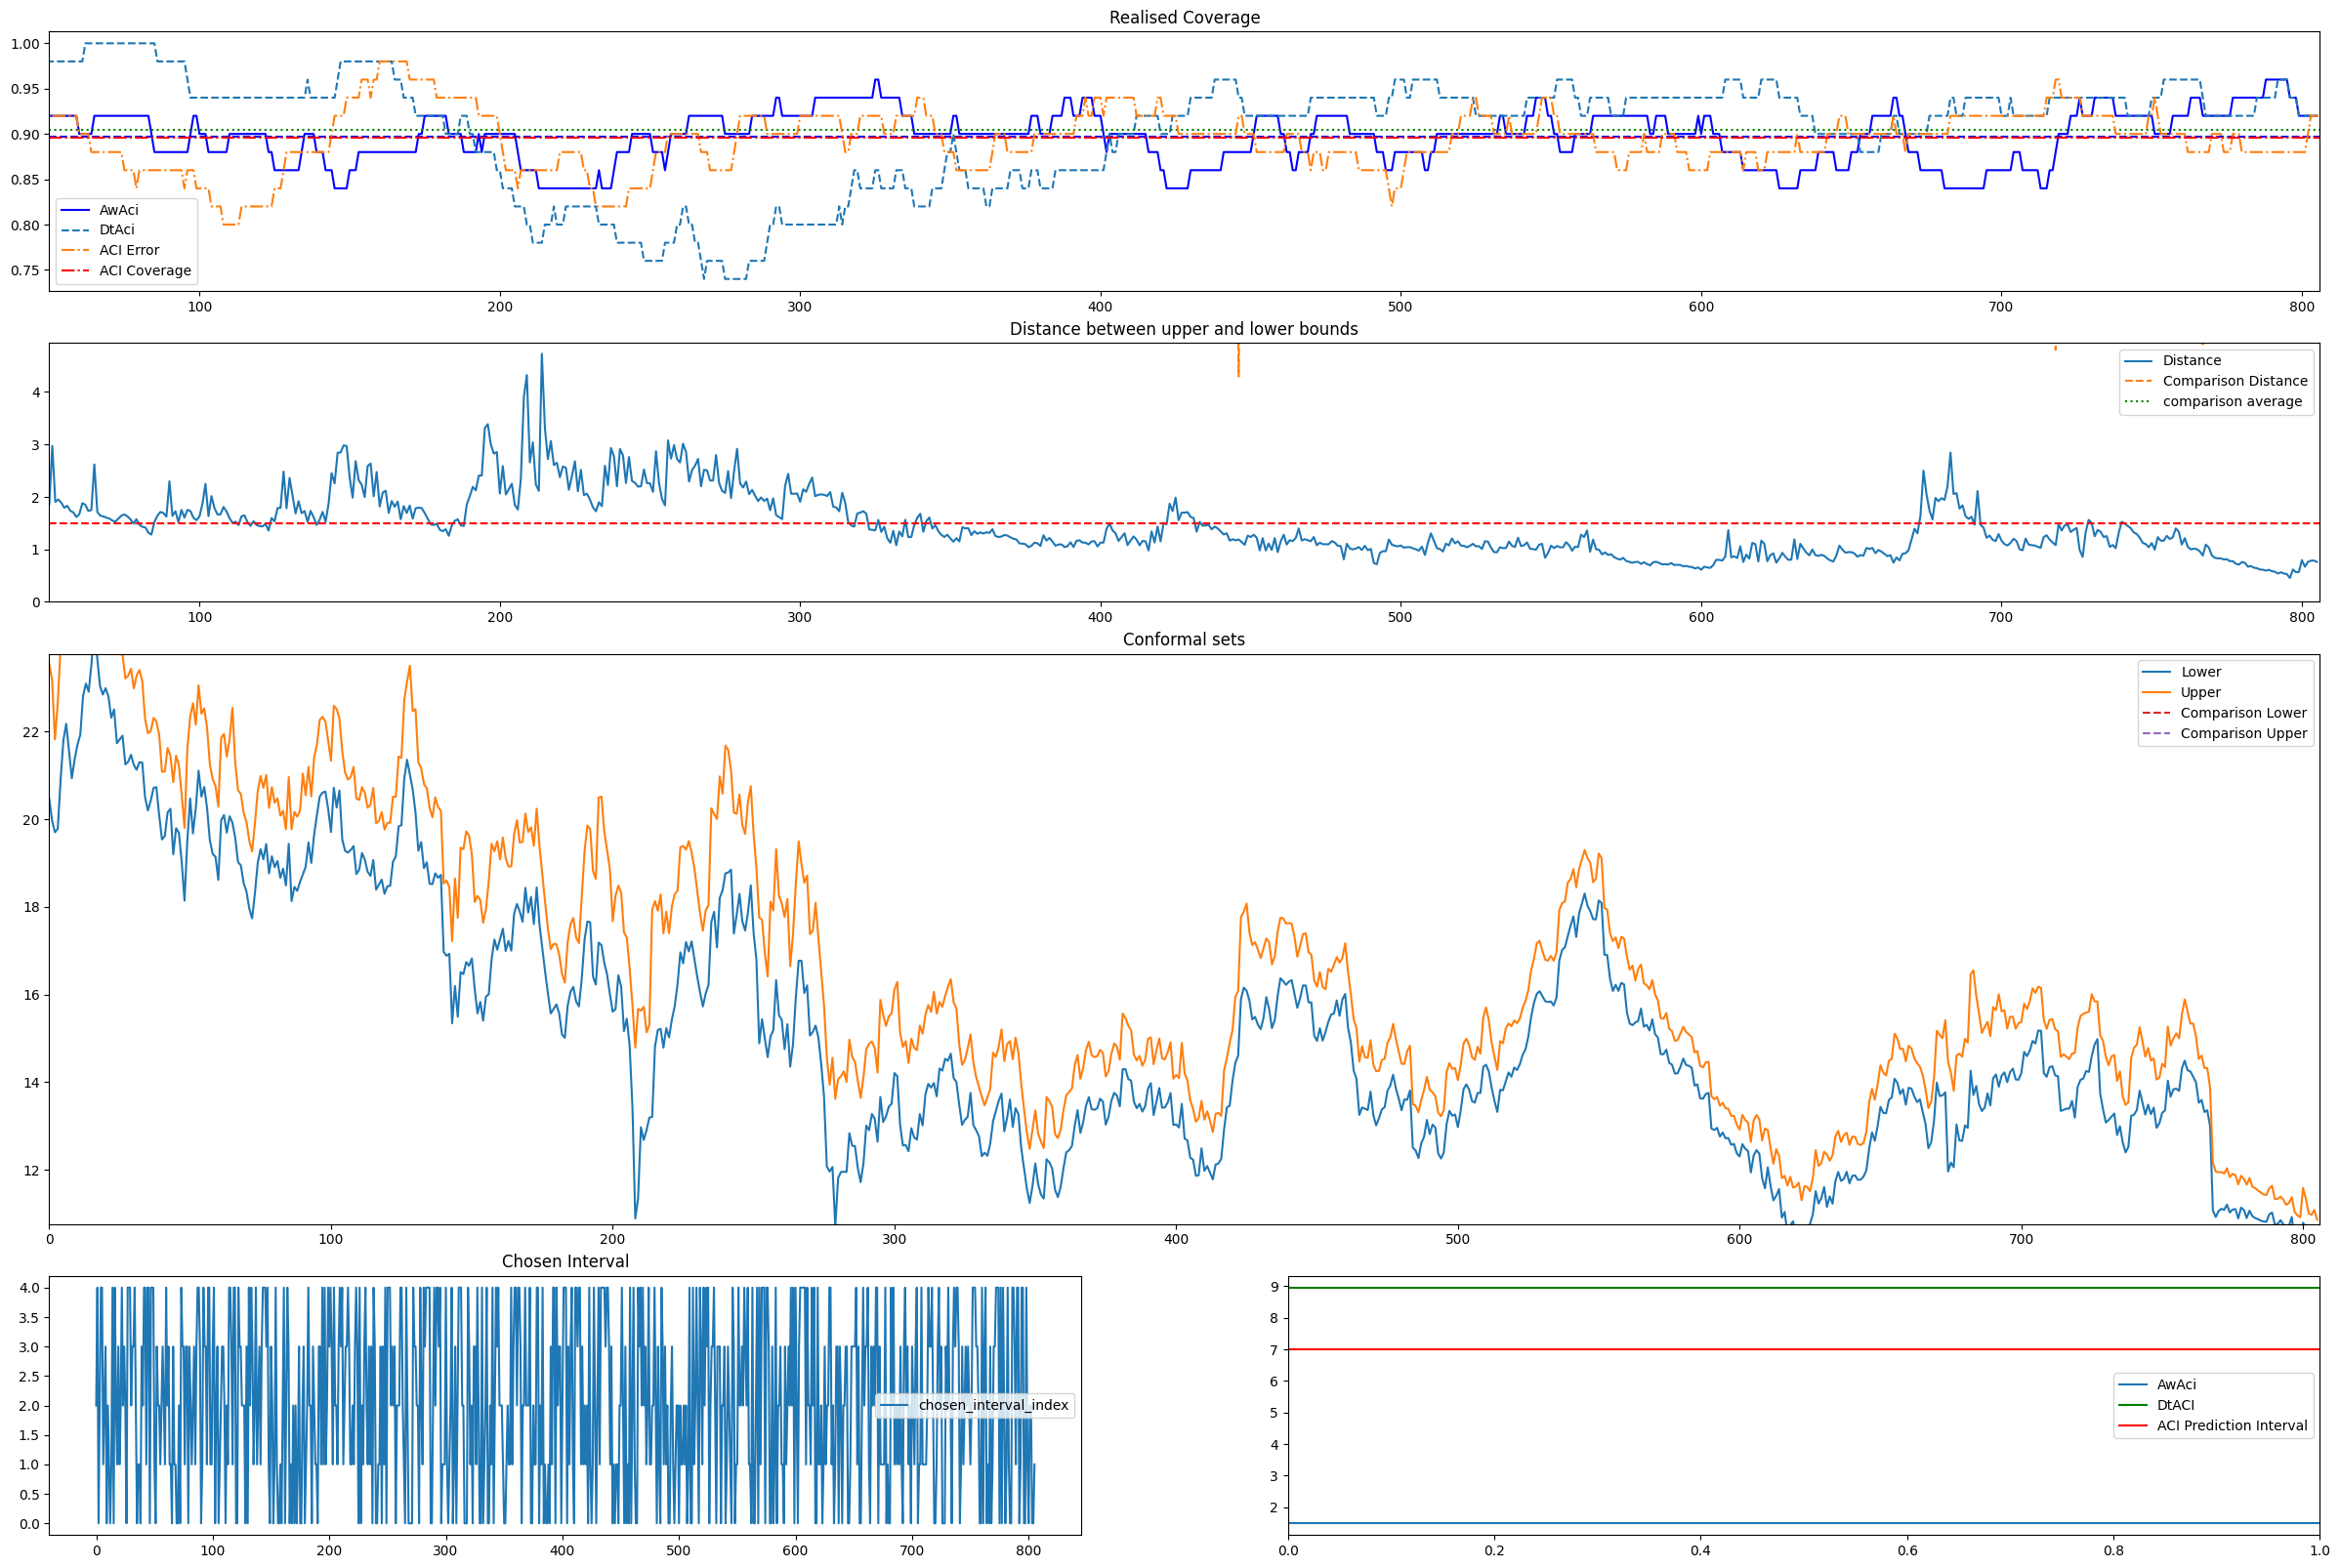

In [33]:
ptest = pinball_ACP.AwACI(stock_data[1], nu_sigma=(1, 0.1))
vtest = ACP.AwACI(stock_data[1], nu_sigma=(1, 0.1))

ACP_plots.compare_two(vtest, ptest)
ACP_plots.AwDT_plot(vtest, stock_data[0], True)
ACP_plots.AwDT_plot(ptest, stock_data[0], True)